In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys, os, os.path, time
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.autograd import Variable
from Net_mModal import Net, NewNet, TransformerEncoder, Transformer, MMTEncoder, LateFusion, videoModel, SuperLateFusion
from util_out import *
from util_f1 import *
from AudioResNet import resnet50
# from AST import ASTModel
from ast_models_original import ASTModel
%matplotlib inline
import subprocess
import pickle
import socket
import matplotlib.pyplot as plt
import h5py

In [2]:
curr_node = socket.gethostname().split('.')[0]
batcmd=f"squeue -u billyli | grep {curr_node}"
curr_slurm = subprocess.check_output(batcmd, shell=True, text=True)
slurm_id = curr_slurm.strip().split(' ')[0]
print(slurm_id)

8674602


In [3]:
torch.cuda.is_available()
torch.cuda.device_count()

1

# VICTIM MODEL

In [4]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("--model_type", type=str, default='ast', help="the model used")
parser.add_argument("--dataset", type=str, default="audioset_s", help="the dataset used", choices=["audioset","audioset_s", "esc50", "speechcommands"])
parser.add_argument("--n_mels", type=int, default=128, help="number of mel bins")
parser.add_argument("--dataset-portion", type=str, default='full', help="balance set or full set")
parser.add_argument('--mean', default=-12.7508, type=float, help='normalizing mean')
parser.add_argument('--std', default=11.7584, type=float, help='normalizing std')

parser.add_argument("--exp-dir", type=str, default="", help="directory to dump experiments")
parser.add_argument('--lr', '--learning-rate', default="0.001", type=str, metavar='LR', help='initial learning rate')
parser.add_argument("--optim", type=str, default="adam", help="training optimizer", choices=["sgd", "adam"])
parser.add_argument('-b', '--batch-size', default=12, type=int, metavar='N', help='mini-batch size')
parser.add_argument('-w', '--num-workers', default=32, type=int, metavar='NW', help='# of workers for dataloading (default: 32)')
parser.add_argument("--n-epochs", type=int, default=1, help="number of maximum training epochs")
# not used in the formal experiments
parser.add_argument("--lr_patience", type=int, default=2, help="how many epoch to wait to reduce lr if mAP doesn't improve")

parser.add_argument("--n-print-steps", type=int, default=100, help="number of steps to print statistics")

parser.add_argument('--freqm', help='frequency mask max length', type=int, default=0)
parser.add_argument('--timem', help='time mask max length', type=int, default=0)
parser.add_argument("--mixup", type=float, default=0, help="how many (0-1) samples need to be mixup during training")
parser.add_argument("--bal", type=str, default=None, help="use balanced sampling or not")
# the stride used in patch spliting, e.g., for patch size 16*16, a stride of 16 means no overlapping, a stride of 10 means overlap of 6.
parser.add_argument("--fstride", type=int, default=8, help="soft split freq stride, overlap=patch_size-stride")
parser.add_argument("--tstride", type=int, default=8, help="soft split time stride, overlap=patch_size-stride")
parser.add_argument('--imagenet_pretrain', help='if use ImageNet pretrained audio spectrogram transformer model', type=bool, default='True')
parser.add_argument('--audioset_pretrain', help='if use ImageNet and audioset pretrained audio spectrogram transformer model', type=bool, default='False')
parser.add_argument('--suffix', type=str, default='')


_StoreAction(option_strings=['--suffix'], dest='suffix', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help=None, metavar=None)

### AST 64x400 best model

In [5]:
args = parser.parse_args(args=['--model_type=AST','--dataset=audioset_s','--n_mels=64', '--mean=-27.248297','--std=37.681698',
                               '--lr=1e-5','--batch-size=80','--n-epochs=10','--fstride=8','--tstride=8',
                               '--freqm=12','--timem=75','--mixup=0.5',
                               '--imagenet_pretrain=True','--suffix=ast_challenge-40.95'])
args.target_length=400
exp_id = f"{args.dataset}-{args.dataset_portion}-f{args.fstride}-t{args.tstride}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}\
-fm{args.freqm}-tm{args.timem}-mix{args.mixup}-m{args.mean}-std{args.std}-epoch{args.n_epochs}-{args.suffix}"
print(exp_id)
WORKSPACE = '/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp'
MODEL_FILE = os.path.join(WORKSPACE, exp_id, 'models', 'audio_model.9.pth')

audioset_s-full-f8-t8-pTrue-b80-lr1e-5-fm12-tm75-mix0.5-m-27.248297-std37.681698-epoch10-ast_challenge-40.95


### AST 128x1024 best model

In [6]:
# args = parser.parse_args(args=['--model_type=AST','--dataset=audioset','--n_mels=128', '--mean=-3.6788461','--std=4.3739743',
#                                '--lr=1e-5','--batch-size=20','--n-epochs=10','--fstride=10','--tstride=10',
#                                '--freqm=36','--timem=192','--mixup=0.3',
#                                '--imagenet_pretrain=True','--suffix=ast_challenge-43.0'])
# args.target_length=1024
# exp_id = f"{args.dataset}-{args.dataset_portion}-f{args.fstride}-t{args.tstride}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}\
# -fm{args.freqm}-tm{args.timem}-mix{args.mixup}-m{args.mean}-std{args.std}-epoch{args.n_epochs}-{args.suffix}"
# print(exp_id)
# WORKSPACE = '/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp'
# MODEL_FILE = os.path.join(WORKSPACE, exp_id, 'models', 'audio_model.3.pth')

In [7]:
print(MODEL_FILE)

/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp/audioset_s-full-f8-t8-pTrue-b80-lr1e-5-fm12-tm75-mix0.5-m-27.248297-std37.681698-epoch10-ast_challenge-40.95/models/audio_model.9.pth


In [8]:
args

Namespace(audioset_pretrain=True, bal=None, batch_size=80, dataset='audioset_s', dataset_portion='full', exp_dir='', freqm=12, fstride=8, imagenet_pretrain=True, lr='1e-5', lr_patience=2, mean=-27.248297, mixup=0.5, model_type='AST', n_epochs=10, n_mels=64, n_print_steps=100, num_workers=32, optim='adam', std=37.681698, suffix='ast_challenge-40.95', target_length=400, timem=75, tstride=8)

In [9]:
# Load model
#model = Net(args).cuda()
if args.model_type == 'TAL':
    model = Net(args).cuda()
elif args.model_type == 'TAL-trans':
    model = TransformerEncoder(args).cuda()
elif args.model_type == 'TAL-new':
    model = NewNet(args).cuda()
elif args.model_type == 'Trans':
    model = Transformer(args).cuda()
elif args.model_type == 'resnet':
    model = resnet50().cuda()
elif args.model_type == 'MMT':
    model = MMTEncoder(args).cuda()
elif args.model_type == 'VM':
    model = videoModel(args).cuda()
elif args.model_type == 'MMTLF':
    model = LateFusion(args).cuda()
elif args.model_type == 'AST':
    model = ASTModel(label_dim=527, fstride=args.fstride, tstride=args.tstride, input_fdim=args.n_mels, input_tdim=args.target_length, imagenet_pretrain=args.imagenet_pretrain, audioset_pretrain=False).cuda()
else:
    print ('model type not recognized')
    exit(0)


---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False
input_fdim: 64,input_tdim: 400
out_shape: torch.Size([1, 768, 7, 49])
f_dim: 7,t_dim: 49, num_patches: 343
frequncey stride=8, time stride=8
number of patches=343
pos_embedding reshaped shape: torch.Size([1, 345, 768])


/jet/home/billyli/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [10]:
optimizer = Adam(model.parameters())


In [11]:
prev_ckpt = torch.load(MODEL_FILE)
# start_ckpt = prev_ckpt['epoch']
# scheduler.load_state_dict(prev_ckpt['scheduler'])
# model = nn.DataParallel(model)
temp = {}
for key, val in prev_ckpt.items():
    key = key.replace('module.','')
    temp[key] = val
model.load_state_dict(temp)
# optimizer.load_state_dict(prev_ckpt['optimizer'])
# write_log('Loading model from %s' % args.continue_from_ckpt)
model.eval()

ASTModel(
  (v): DistilledVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(8, 8))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((768,)

In [12]:
N_CLASSES = 527
N_WORKERS = 6
local = f"/local/slurm-{slurm_id}/local/audio"
if args.dataset == 'audioset_s':
    hf_val_eval_path = os.path.join(local, 'data_64_400_again.h5')
elif args.dataset == 'audioset':
    hf_val_eval_path = os.path.join(local, 'data_128_1024_again.h5')
# hf_val_eval_path = os.path.join(local, 'data_128_1024_strong_cleaned.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

In [13]:
gas_eval_x1, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

In [14]:
gas_eval_x1.shape, gas_eval_y.shape, mu_val, sigma_val

((20123, 400, 64), (20123, 527), -27.248297, 37.681698)

# Inference

In [15]:
result = []
batch_size =100
x = gas_eval_x1 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]


total num of batches during testing 202


In [16]:
print(output,'max:', torch.max(output), 'min: ', torch.min(output))

tensor([[7.3389e-01, 5.8899e-03, 1.2350e-03,  ..., 2.6727e-04, 1.1683e-04,
         8.9586e-05],
        [3.6377e-01, 4.2224e-04, 2.6941e-04,  ..., 9.9182e-05, 2.5320e-04,
         2.4152e-04],
        [8.5645e-01, 1.7271e-03, 4.5466e-04,  ..., 3.2258e-04, 5.8770e-05,
         5.6505e-05],
        ...,
        [1.6052e-01, 3.3894e-03, 2.9812e-03,  ..., 4.0703e-03, 9.0561e-03,
         1.5669e-03],
        [3.9902e-03, 1.9872e-04, 1.6606e-04,  ..., 7.8249e-04, 2.5711e-03,
         7.7248e-05],
        [8.7433e-03, 4.6563e-04, 9.9182e-05,  ..., 7.7343e-04, 8.0109e-04,
         3.4695e-03]], device='cuda:0', dtype=torch.float16) max: tensor(0.9590, device='cuda:0', dtype=torch.float16) min:  tensor(1.0729e-06, device='cuda:0', dtype=torch.float16)


In [17]:
print(result[0].shape)

(20123, 527)


In [18]:
gas_eval_global_prob_multi = result[0]
print(gas_eval_global_prob_multi.shape)

(20123, 527)


In [19]:
print(gas_eval_global_prob_multi,'max:', np.max(gas_eval_global_prob_multi), 'min: ', np.min(gas_eval_global_prob_multi))

[[1.1421e-02 8.0729e-04 1.0242e-03 ... 3.4189e-04 3.4070e-04 1.1325e-04]
 [3.3740e-01 4.0126e-04 1.9717e-04 ... 1.4782e-03 3.1242e-03 2.0752e-03]
 [1.1084e-01 4.9629e-03 1.6747e-03 ... 1.3304e-03 1.3304e-03 2.0993e-04]
 ...
 [1.6052e-01 3.3894e-03 2.9812e-03 ... 4.0703e-03 9.0561e-03 1.5669e-03]
 [3.9902e-03 1.9872e-04 1.6606e-04 ... 7.8249e-04 2.5711e-03 7.7248e-05]
 [8.7433e-03 4.6563e-04 9.9182e-05 ... 7.7343e-04 8.0109e-04 3.4695e-03]] max: 0.9966 min:  4e-07


In [20]:
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)

Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------


In [21]:
import numpy as np
from scipy import stats
from sklearn import metrics
import torch

def d_prime(auc):
    standard_normal = stats.norm()
    d_prime = standard_normal.ppf(auc) * np.sqrt(2.0)
    return d_prime

def calculate_stats(output, target):
    """Calculate statistics including mAP, AUC, etc.
    Args:
      output: 2d array, (samples_num, classes_num)
      target: 2d array, (samples_num, classes_num)
    Returns:
      stats: list of statistic of each class.
    """

    classes_num = target.shape[-1]
    stats = []

    # Accuracy, only used for single-label classification such as esc-50, not for multiple label one such as AudioSet
    acc = metrics.accuracy_score(np.argmax(target, 1), np.argmax(output, 1))

    # Class-wise statistics
    for k in range(classes_num):

        # Average precision
        avg_precision = metrics.average_precision_score(
            target[:, k], output[:, k], average=None)

        # AUC
        auc = metrics.roc_auc_score(target[:, k], output[:, k], average=None)

        # Precisions, recalls
        (precisions, recalls, thresholds) = metrics.precision_recall_curve(
            target[:, k], output[:, k])

        # FPR, TPR
        (fpr, tpr, thresholds) = metrics.roc_curve(target[:, k], output[:, k])

        save_every_steps = 1000     # Sample statistics to reduce size
        dict = {'precisions': precisions[0::save_every_steps],
                'recalls': recalls[0::save_every_steps],
                'AP': avg_precision,
                'fpr': fpr[0::save_every_steps],
                'fnr': 1. - tpr[0::save_every_steps],
                'auc': auc,
                # note acc is not class-wise, this is just to keep consistent with other metrics
                'acc': acc
                }
        stats.append(dict)

    return stats

In [22]:
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

mAP, AUC, dprime: 0.40953865684470986 0.9725381601878107 2.7145539262030653
 Average | 0.410 | 0.973 | 2.715 
---------+-------+-------+-------
       0 | 0.793 | 0.934 | 2.125 
       1 | 0.065 | 0.815 | 1.265 
       2 | 0.093 | 0.923 | 2.017 
       3 | 0.371 | 0.962 | 2.512 
       4 | 0.245 | 0.974 | 2.756 
       5 | 0.088 | 0.952 | 2.352 
       6 | 0.474 | 0.997 | 3.815 
       7 | 0.453 | 0.988 | 3.190 
       8 | 0.144 | 0.945 | 2.257 
       9 | 0.095 | 0.951 | 2.340 
      10 | 0.139 | 0.965 | 2.563 
      11 | 0.186 | 0.978 | 2.849 
      12 | 0.835 | 0.999 | 4.446 
      13 | 0.512 | 0.996 | 3.731 
      14 | 0.336 | 0.987 | 3.143 
      15 | 0.823 | 0.999 | 4.234 
      16 | 0.392 | 0.978 | 2.848 
      17 | 0.604 | 0.993 | 3.485 
      18 | 0.158 | 0.979 | 2.889 
      19 | 0.255 | 0.980 | 2.900 
      20 | 0.359 | 0.990 | 3.277 
      21 | 0.220 | 0.983 | 2.986 
      22 | 0.465 | 0.990 | 3.296 
      23 | 0.435 | 0.988 | 3.188 
      24 | 0.197 | 0.967 | 2.591 
      

In [31]:
print(np.max(gas_eval_global_prob_multi), np.min(gas_eval_global_prob_multi))

0.9966 4e-07


In [27]:
print(gas_eval_y.shape)

(20123, 527)


In [24]:
with open("Analysis/pred.pkl", "wb") as f:
    pickle.dump(gas_eval_global_prob_multi, f)

In [25]:
with open("Analysis/truth.pkl", "wb") as f:
    pickle.dump(gas_eval_y, f)

### Wrong evaluation Result somehow

In [30]:
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = np.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

0.41093723164743673 0.8366745745431141 1.3871768682446737
 Average | 0.411 | 0.837 | 1.387 
---------+-------+-------+-------
       0 | 0.874 | 0.916 | 1.951 
       1 | 0.072 | 0.405 |-0.341 
       2 | 0.097 | 0.597 | 0.349 
       3 | 0.375 | 0.754 | 0.970 
       4 | 0.245 | 0.804 | 1.210 
       5 | 0.089 | 0.696 | 0.723 
       6 | 0.474 | 0.966 | 2.577 
       7 | 0.453 | 0.901 | 1.818 
       8 | 0.145 | 0.656 | 0.570 
       9 | 0.097 | 0.658 | 0.574 
      10 | 0.140 | 0.759 | 0.995 
      11 | 0.186 | 0.817 | 1.280 
      12 | 0.835 | 0.992 | 3.396 
      13 | 0.512 | 0.959 | 2.463 
      14 | 0.336 | 0.881 | 1.672 
      15 | 0.823 | 0.987 | 3.128 
      16 | 0.393 | 0.826 | 1.329 
      17 | 0.604 | 0.933 | 2.117 
      18 | 0.159 | 0.819 | 1.290 
      19 | 0.255 | 0.811 | 1.249 
      20 | 0.359 | 0.908 | 1.879 
      21 | 0.220 | 0.830 | 1.349 
      22 | 0.465 | 0.903 | 1.839 
      23 | 0.435 | 0.902 | 1.825 
      24 | 0.198 | 0.728 | 0.857 
      25 | 0.185 | 0.710

# Occlusion

In [62]:
gas_eval_x1_origin = gas_eval_x1

In [63]:
min_val = numpy.min(gas_eval_x1)
max_val = numpy.max(gas_eval_x1)
mean_val = numpy.mean(gas_eval_x1)
std_val = numpy.std(gas_eval_x1)
print(min_val, max_val, mean_val, std_val)

-2.2922494 1.4197426 -0.158013 0.62080556


In [64]:
gas_eval_x1.shape

(20123, 400, 64)

<h>Occ 4s</h>

In [65]:
new_gas_eval = []
time_frame = 400
step = 80
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

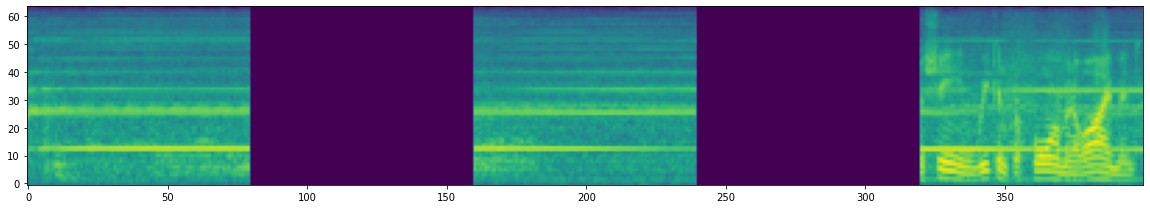

In [66]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [68]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.35813899585971976 0.9638208808546115 2.5411403075334036
 Average | 0.358 | 0.964 | 2.541 
---------+-------+-------+-------
       0 | 0.759 | 0.918 | 1.964 
       1 | 0.069 | 0.807 | 1.227 
       2 | 0.086 | 0.915 | 1.945 
       3 | 0.331 | 0.951 | 2.346 
       4 | 0.178 | 0.972 | 2.707 
       5 | 0.064 | 0.949 | 2.314 
       6 | 0.411 | 0.990 | 3.281 
       7 | 0.343 | 0.988 | 3.211 
       8 | 0.117 | 0.937 | 2.169 
       9 | 0.086 | 0.942 | 2.222 
      10 | 0.103 | 0.953 | 2.364 
      11 | 0.202 | 0.974 | 2.756 
      12 | 0.796 | 0.999 | 4.285 
      13 | 0.436 | 0.995 | 3.659 
      14 | 0.258 | 0.971 | 2.687 
      15 | 0.753 | 0.995 | 3.620 
      16 | 0.342 | 0.975 | 2.776 
      17 | 0.553 | 0.992 | 3.433 
      18 | 0.117 | 0.974 | 2.742 
      19 | 0.190 | 0.967 | 2.591 
      20 | 0.311 | 0.987 | 3.158 
 

<h>First 5s</h>

In [69]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[:200]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

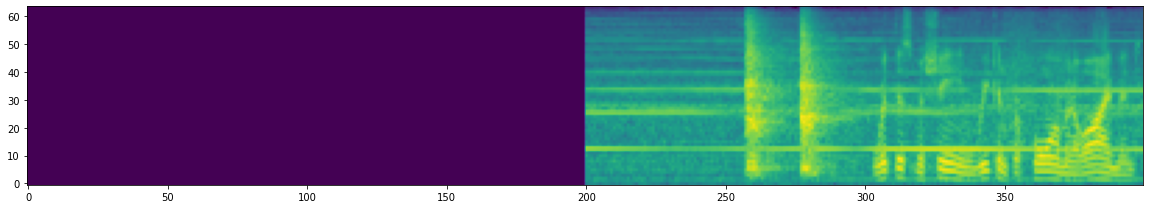

In [70]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')
plt.savefig('imgs/first_5s_occlusion.png')

In [71]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.318588136948276 0.9468110808924216 2.2835165360251506
 Average | 0.319 | 0.947 | 2.284 
---------+-------+-------+-------
       0 | 0.710 | 0.884 | 1.690 
       1 | 0.055 | 0.804 | 1.210 
       2 | 0.080 | 0.914 | 1.930 
       3 | 0.306 | 0.940 | 2.194 
       4 | 0.138 | 0.955 | 2.391 
       5 | 0.049 | 0.951 | 2.337 
       6 | 0.297 | 0.961 | 2.487 
       7 | 0.212 | 0.987 | 3.138 
       8 | 0.111 | 0.928 | 2.065 
       9 | 0.099 | 0.942 | 2.221 
      10 | 0.072 | 0.934 | 2.133 
      11 | 0.129 | 0.942 | 2.226 
      12 | 0.717 | 0.995 | 3.622 
      13 | 0.434 | 0.987 | 3.165 
      14 | 0.261 | 0.970 | 2.669 
      15 | 0.646 | 0.969 | 2.630 
      16 | 0.306 | 0.965 | 2.565 
      17 | 0.410 | 0.987 | 3.154 
      18 | 0.110 | 0.940 | 2.204 
      19 | 0.155 | 0.931 | 2.102 
      20 | 0.310 | 0.969 | 2.644 
   

<h>mid 5s</h>

In [72]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[100:300]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

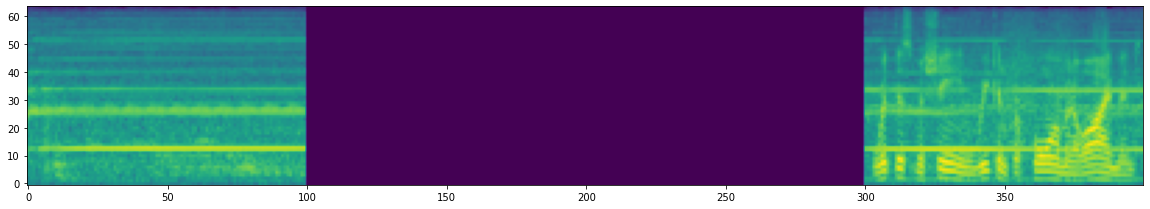

In [73]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [74]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.3348026683686424 0.9562146489911072 2.4159772063814704
 Average | 0.335 | 0.956 | 2.416 
---------+-------+-------+-------
       0 | 0.728 | 0.903 | 1.833 
       1 | 0.037 | 0.816 | 1.272 
       2 | 0.088 | 0.915 | 1.943 
       3 | 0.292 | 0.940 | 2.199 
       4 | 0.179 | 0.969 | 2.642 
       5 | 0.059 | 0.939 | 2.193 
       6 | 0.347 | 0.978 | 2.846 
       7 | 0.312 | 0.987 | 3.139 
       8 | 0.098 | 0.942 | 2.227 
       9 | 0.088 | 0.938 | 2.176 
      10 | 0.096 | 0.954 | 2.377 
      11 | 0.145 | 0.962 | 2.516 
      12 | 0.721 | 0.995 | 3.675 
      13 | 0.396 | 0.994 | 3.582 
      14 | 0.169 | 0.959 | 2.458 
      15 | 0.722 | 0.978 | 2.858 
      16 | 0.332 | 0.967 | 2.608 
      17 | 0.492 | 0.979 | 2.865 
      18 | 0.138 | 0.960 | 2.473 
      19 | 0.175 | 0.951 | 2.346 
      20 | 0.316 | 0.975 | 2.768 
  

<h>last 5s</h>

In [75]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[200:400]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

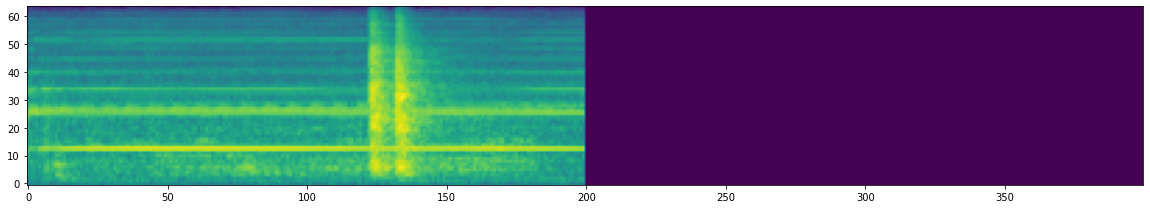

In [76]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [77]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.3279369589506534 0.9486302050341732 2.3075931387686888
 Average | 0.328 | 0.949 | 2.308 
---------+-------+-------+-------
       0 | 0.721 | 0.886 | 1.702 
       1 | 0.029 | 0.805 | 1.217 
       2 | 0.079 | 0.896 | 1.782 
       3 | 0.226 | 0.936 | 2.156 
       4 | 0.131 | 0.957 | 2.428 
       5 | 0.048 | 0.932 | 2.104 
       6 | 0.325 | 0.966 | 2.588 
       7 | 0.268 | 0.976 | 2.792 
       8 | 0.111 | 0.921 | 1.998 
       9 | 0.087 | 0.917 | 1.963 
      10 | 0.096 | 0.947 | 2.284 
      11 | 0.190 | 0.967 | 2.591 
      12 | 0.837 | 0.999 | 4.359 
      13 | 0.318 | 0.972 | 2.698 
      14 | 0.167 | 0.944 | 2.248 
      15 | 0.793 | 0.984 | 3.032 
      16 | 0.321 | 0.960 | 2.474 
      17 | 0.555 | 0.972 | 2.692 
      18 | 0.174 | 0.953 | 2.364 
      19 | 0.200 | 0.949 | 2.309 
      20 | 0.301 | 0.962 | 2.517 
  

<h>Every 1s</h1>

In [78]:
new_gas_eval = []
time_frame = 400
step = 40
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

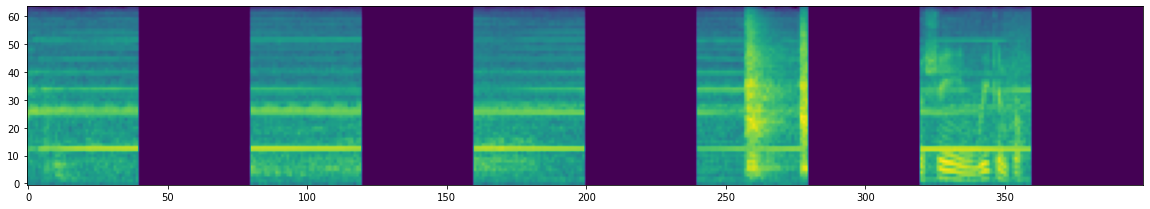

In [79]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [80]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.31885996245971515 0.9562772638937179 2.4169327965155896
 Average | 0.319 | 0.956 | 2.417 
---------+-------+-------+-------
       0 | 0.737 | 0.908 | 1.876 
       1 | 0.061 | 0.784 | 1.109 
       2 | 0.068 | 0.909 | 1.891 
       3 | 0.256 | 0.948 | 2.302 
       4 | 0.115 | 0.965 | 2.567 
       5 | 0.057 | 0.947 | 2.289 
       6 | 0.335 | 0.977 | 2.831 
       7 | 0.272 | 0.982 | 2.956 
       8 | 0.127 | 0.927 | 2.052 
       9 | 0.097 | 0.930 | 2.091 
      10 | 0.087 | 0.948 | 2.300 
      11 | 0.177 | 0.960 | 2.473 
      12 | 0.765 | 0.998 | 4.011 
      13 | 0.333 | 0.994 | 3.542 
      14 | 0.188 | 0.951 | 2.345 
      15 | 0.722 | 0.993 | 3.473 
      16 | 0.343 | 0.968 | 2.619 
      17 | 0.551 | 0.988 | 3.214 
      18 | 0.097 | 0.947 | 2.280 
      19 | 0.137 | 0.962 | 2.506 
      20 | 0.347 | 0.975 | 2.779 
 

Every 0.75s

In [81]:
new_gas_eval = []
time_frame = 400
step = 30
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

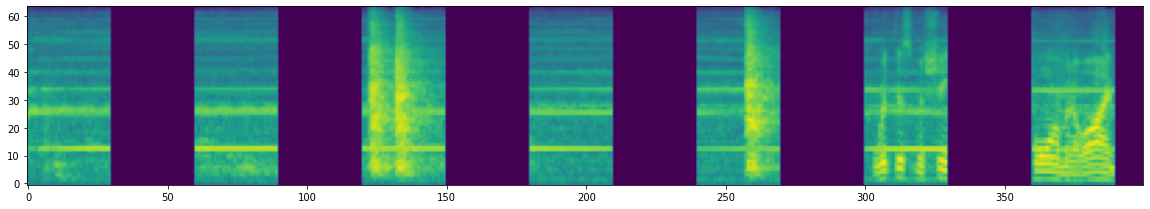

In [82]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [83]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.27184851488673434 0.9468201313509067 2.2836346921612494
 Average | 0.272 | 0.947 | 2.284 
---------+-------+-------+-------
       0 | 0.706 | 0.899 | 1.803 
       1 | 0.033 | 0.797 | 1.173 
       2 | 0.071 | 0.900 | 1.813 
       3 | 0.245 | 0.944 | 2.243 
       4 | 0.181 | 0.970 | 2.663 
       5 | 0.055 | 0.937 | 2.163 
       6 | 0.245 | 0.979 | 2.880 
       7 | 0.194 | 0.982 | 2.960 
       8 | 0.089 | 0.918 | 1.972 
       9 | 0.079 | 0.929 | 2.075 
      10 | 0.073 | 0.954 | 2.389 
      11 | 0.105 | 0.959 | 2.452 
      12 | 0.573 | 0.996 | 3.695 
      13 | 0.302 | 0.991 | 3.360 
      14 | 0.136 | 0.967 | 2.596 
      15 | 0.737 | 0.984 | 3.047 
      16 | 0.324 | 0.965 | 2.563 
      17 | 0.352 | 0.990 | 3.280 
      18 | 0.097 | 0.951 | 2.346 
      19 | 0.124 | 0.962 | 2.504 
      20 | 0.267 | 0.982 | 2.967 
 

<h>Every 0.5s</h1>

In [84]:
new_gas_eval = []
time_frame = 400
step = 20
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

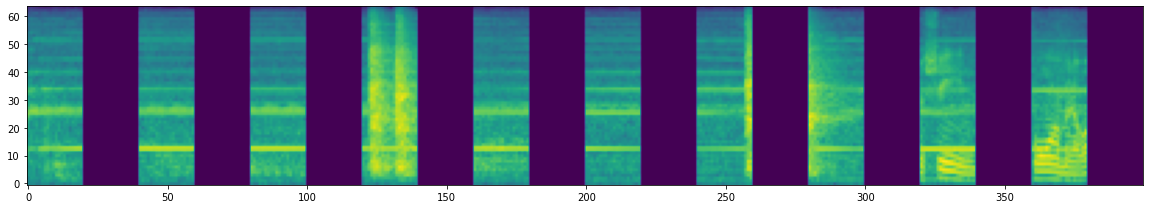

In [85]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [86]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.23266783913561406 0.936909511859495 2.162808814960653
 Average | 0.233 | 0.937 | 2.163 
---------+-------+-------+-------
       0 | 0.686 | 0.891 | 1.743 
       1 | 0.040 | 0.753 | 0.967 
       2 | 0.074 | 0.900 | 1.815 
       3 | 0.230 | 0.938 | 2.174 
       4 | 0.152 | 0.955 | 2.404 
       5 | 0.050 | 0.940 | 2.204 
       6 | 0.227 | 0.979 | 2.870 
       7 | 0.181 | 0.973 | 2.718 
       8 | 0.088 | 0.931 | 2.102 
       9 | 0.084 | 0.918 | 1.971 
      10 | 0.068 | 0.955 | 2.394 
      11 | 0.080 | 0.955 | 2.404 
      12 | 0.616 | 0.995 | 3.616 
      13 | 0.242 | 0.989 | 3.229 
      14 | 0.139 | 0.951 | 2.335 
      15 | 0.734 | 0.995 | 3.600 
      16 | 0.341 | 0.969 | 2.634 
      17 | 0.405 | 0.977 | 2.811 
      18 | 0.091 | 0.953 | 2.362 
      19 | 0.125 | 0.953 | 2.375 
      20 | 0.181 | 0.977 | 2.833 
   

Every 0.375s

In [87]:
new_gas_eval = []
time_frame = 400
step = 15
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

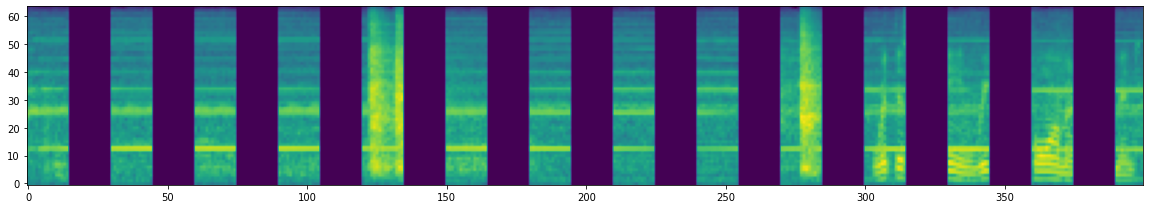

In [88]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [89]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.10779220593981868 0.8693628090054552 1.5887050889384817
 Average | 0.108 | 0.869 | 1.589 
---------+-------+-------+-------
       0 | 0.615 | 0.856 | 1.501 
       1 | 0.008 | 0.739 | 0.904 
       2 | 0.025 | 0.882 | 1.679 
       3 | 0.123 | 0.905 | 1.853 
       4 | 0.089 | 0.941 | 2.217 
       5 | 0.054 | 0.928 | 2.067 
       6 | 0.104 | 0.967 | 2.608 
       7 | 0.076 | 0.945 | 2.262 
       8 | 0.026 | 0.796 | 1.171 
       9 | 0.019 | 0.840 | 1.407 
      10 | 0.032 | 0.875 | 1.627 
      11 | 0.039 | 0.849 | 1.459 
      12 | 0.255 | 0.958 | 2.442 
      13 | 0.134 | 0.917 | 1.960 
      14 | 0.060 | 0.914 | 1.929 
      15 | 0.506 | 0.958 | 2.444 
      16 | 0.248 | 0.949 | 2.312 
      17 | 0.368 | 0.979 | 2.867 
      18 | 0.103 | 0.933 | 2.123 
      19 | 0.073 | 0.926 | 2.043 
      20 | 0.129 | 0.968 | 2.610 
 

<h>Every 0.25s</h1>

In [90]:
new_gas_eval = []
time_frame = 400
step = 10
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

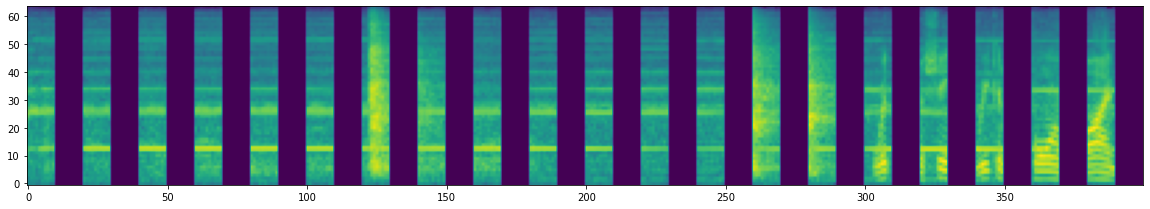

In [91]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [92]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.04145379793540853 0.7569740125009974 0.9851438352993901
 Average | 0.041 | 0.757 | 0.985 
---------+-------+-------+-------
       0 | 0.504 | 0.768 | 1.037 
       1 | 0.004 | 0.589 | 0.318 
       2 | 0.012 | 0.773 | 1.060 
       3 | 0.068 | 0.826 | 1.327 
       4 | 0.014 | 0.834 | 1.372 
       5 | 0.019 | 0.859 | 1.519 
       6 | 0.045 | 0.936 | 2.157 
       7 | 0.016 | 0.863 | 1.547 
       8 | 0.005 | 0.671 | 0.625 
       9 | 0.007 | 0.681 | 0.664 
      10 | 0.008 | 0.761 | 1.005 
      11 | 0.004 | 0.641 | 0.509 
      12 | 0.015 | 0.842 | 1.417 
      13 | 0.019 | 0.794 | 1.158 
      14 | 0.010 | 0.798 | 1.179 
      15 | 0.390 | 0.974 | 2.759 
      16 | 0.083 | 0.890 | 1.733 
      17 | 0.081 | 0.897 | 1.790 
      18 | 0.073 | 0.892 | 1.753 
      19 | 0.048 | 0.869 | 1.584 
      20 | 0.046 | 0.914 | 1.931 
 

<h>Every 0.125s</h1>

In [93]:
new_gas_eval = []
time_frame = 400
step = 5
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

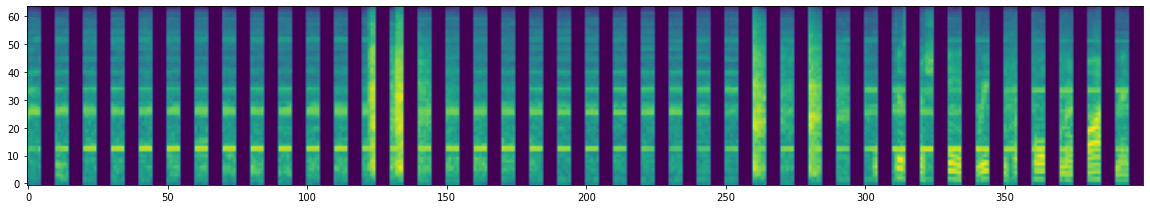

In [94]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [95]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.020166019365756446 0.6750199874990809 0.6417951813702377
 Average | 0.020 | 0.675 | 0.642 
---------+-------+-------+-------
       0 | 0.430 | 0.696 | 0.724 
       1 | 0.005 | 0.603 | 0.371 
       2 | 0.011 | 0.729 | 0.861 
       3 | 0.035 | 0.726 | 0.848 
       4 | 0.011 | 0.816 | 1.273 
       5 | 0.010 | 0.719 | 0.820 
       6 | 0.016 | 0.877 | 1.637 
       7 | 0.005 | 0.700 | 0.742 
       8 | 0.004 | 0.501 | 0.004 
       9 | 0.007 | 0.627 | 0.458 
      10 | 0.006 | 0.727 | 0.853 
      11 | 0.004 | 0.651 | 0.550 
      12 | 0.005 | 0.612 | 0.401 
      13 | 0.025 | 0.772 | 1.054 
      14 | 0.004 | 0.608 | 0.388 
      15 | 0.213 | 0.972 | 2.700 
      16 | 0.029 | 0.786 | 1.122 
      17 | 0.020 | 0.803 | 1.206 
      18 | 0.017 | 0.823 | 1.309 
      19 | 0.011 | 0.740 | 0.910 
      20 | 0.015 | 0.779 | 1.089 


<h>concat 0.125s</h>

In [96]:
new_gas_eval = []
time_frame = 400
step = 5
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

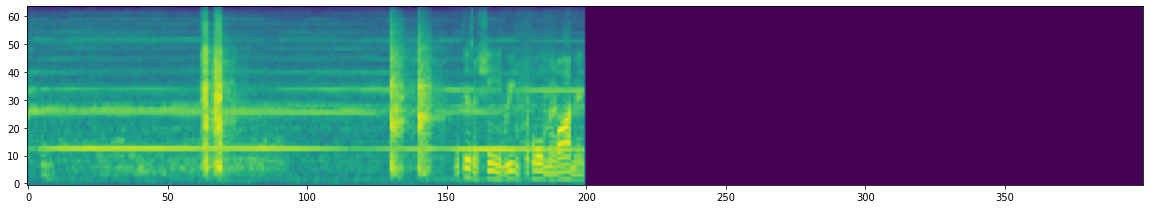

In [97]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [98]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.2909620512719171 0.9517228837448466 2.350130577514095
 Average | 0.291 | 0.952 | 2.350 
---------+-------+-------+-------
       0 | 0.707 | 0.902 | 1.830 
       1 | 0.086 | 0.817 | 1.281 
       2 | 0.088 | 0.912 | 1.913 
       3 | 0.219 | 0.943 | 2.238 
       4 | 0.138 | 0.974 | 2.743 
       5 | 0.074 | 0.943 | 2.229 
       6 | 0.236 | 0.985 | 3.067 
       7 | 0.354 | 0.982 | 2.967 
       8 | 0.097 | 0.908 | 1.877 
       9 | 0.104 | 0.939 | 2.184 
      10 | 0.097 | 0.950 | 2.330 
      11 | 0.151 | 0.969 | 2.645 
      12 | 0.651 | 0.995 | 3.676 
      13 | 0.377 | 0.995 | 3.616 
      14 | 0.173 | 0.966 | 2.577 
      15 | 0.674 | 0.988 | 3.193 
      16 | 0.284 | 0.971 | 2.682 
      17 | 0.453 | 0.978 | 2.841 
      18 | 0.096 | 0.940 | 2.204 
      19 | 0.120 | 0.961 | 2.495 
      20 | 0.289 | 0.969 | 2.638 
   

<h>concat 0.25s</h>

In [99]:
new_gas_eval = []
time_frame = 400
step = 10
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

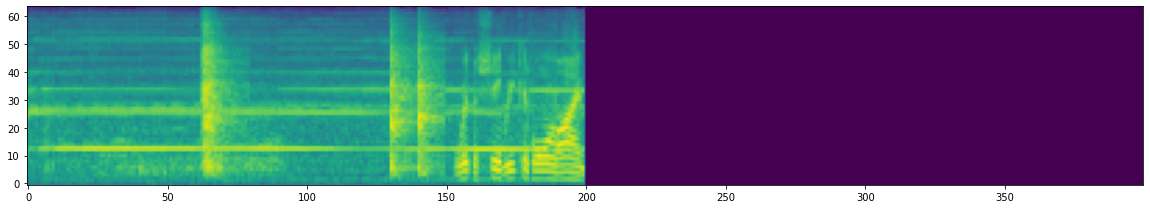

In [100]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [101]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.3108205507737351 0.957233118235184 2.4316594133519915
 Average | 0.311 | 0.957 | 2.432 
---------+-------+-------+-------
       0 | 0.723 | 0.907 | 1.871 
       1 | 0.082 | 0.821 | 1.299 
       2 | 0.058 | 0.905 | 1.850 
       3 | 0.248 | 0.950 | 2.323 
       4 | 0.176 | 0.972 | 2.713 
       5 | 0.110 | 0.959 | 2.458 
       6 | 0.333 | 0.984 | 3.026 
       7 | 0.364 | 0.986 | 3.103 
       8 | 0.107 | 0.925 | 2.040 
       9 | 0.075 | 0.926 | 2.049 
      10 | 0.097 | 0.954 | 2.380 
      11 | 0.128 | 0.963 | 2.521 
      12 | 0.754 | 0.999 | 4.282 
      13 | 0.436 | 0.995 | 3.635 
      14 | 0.232 | 0.970 | 2.660 
      15 | 0.677 | 0.994 | 3.561 
      16 | 0.340 | 0.971 | 2.678 
      17 | 0.496 | 0.986 | 3.126 
      18 | 0.138 | 0.961 | 2.492 
      19 | 0.184 | 0.964 | 2.536 
      20 | 0.285 | 0.986 | 3.110 
   

<h>concat 0.5s</h>

In [113]:
new_gas_eval = []
time_frame = 400
step = 20
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

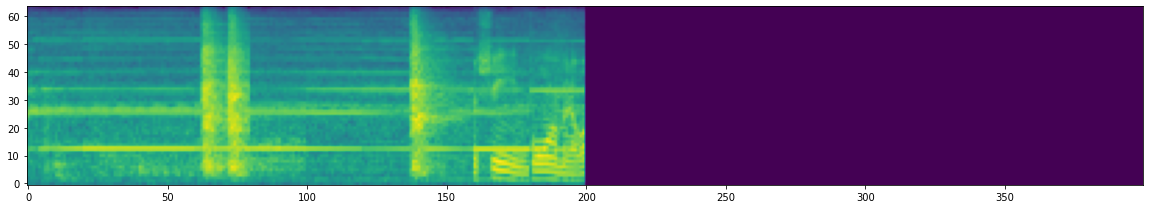

In [114]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [115]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.3308433634229894 0.9601474016815397 2.4782666517992538
 Average | 0.331 | 0.960 | 2.478 
---------+-------+-------+-------
       0 | 0.738 | 0.910 | 1.900 
       1 | 0.096 | 0.808 | 1.232 
       2 | 0.081 | 0.921 | 1.993 
       3 | 0.270 | 0.942 | 2.220 
       4 | 0.169 | 0.973 | 2.735 
       5 | 0.118 | 0.952 | 2.357 
       6 | 0.274 | 0.985 | 3.063 
       7 | 0.381 | 0.987 | 3.128 
       8 | 0.100 | 0.934 | 2.131 
       9 | 0.091 | 0.932 | 2.111 
      10 | 0.079 | 0.957 | 2.433 
      11 | 0.130 | 0.962 | 2.514 
      12 | 0.781 | 0.999 | 4.357 
      13 | 0.464 | 0.995 | 3.685 
      14 | 0.220 | 0.976 | 2.799 
      15 | 0.707 | 0.994 | 3.544 
      16 | 0.340 | 0.971 | 2.673 
      17 | 0.493 | 0.988 | 3.191 
      18 | 0.156 | 0.956 | 2.417 
      19 | 0.173 | 0.962 | 2.507 
      20 | 0.204 | 0.984 | 3.030 
  

<h>concat 1s</h>

In [116]:
new_gas_eval = []
time_frame = 400
step = 40
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

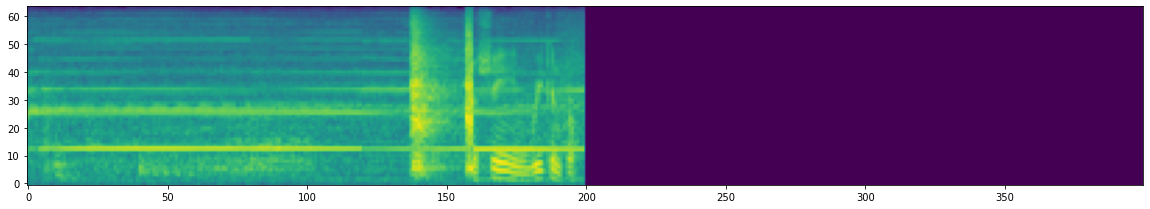

In [117]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [118]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.3380952023046774 0.9598300449716313 2.473059624687355
 Average | 0.338 | 0.960 | 2.473 
---------+-------+-------+-------
       0 | 0.748 | 0.910 | 1.897 
       1 | 0.064 | 0.801 | 1.197 
       2 | 0.085 | 0.913 | 1.921 
       3 | 0.269 | 0.951 | 2.344 
       4 | 0.147 | 0.969 | 2.644 
       5 | 0.086 | 0.946 | 2.268 
       6 | 0.318 | 0.986 | 3.090 
       7 | 0.352 | 0.981 | 2.949 
       8 | 0.150 | 0.934 | 2.135 
       9 | 0.102 | 0.935 | 2.146 
      10 | 0.097 | 0.939 | 2.191 
      11 | 0.147 | 0.966 | 2.586 
      12 | 0.805 | 0.997 | 3.847 
      13 | 0.377 | 0.994 | 3.516 
      14 | 0.198 | 0.953 | 2.373 
      15 | 0.755 | 0.997 | 3.842 
      16 | 0.352 | 0.972 | 2.707 
      17 | 0.520 | 0.990 | 3.294 
      18 | 0.145 | 0.960 | 2.474 
      19 | 0.176 | 0.963 | 2.526 
      20 | 0.325 | 0.983 | 3.005 
   

<h>White noise 2D</h>

In [119]:
import numpy as np
new_gas_eval = []
for record in gas_eval_x1:
    record += np.random.normal(0, 0.1, (400,64))
    new_gas_eval.append(record)
new_gas_eval = numpy.array(new_gas_eval)

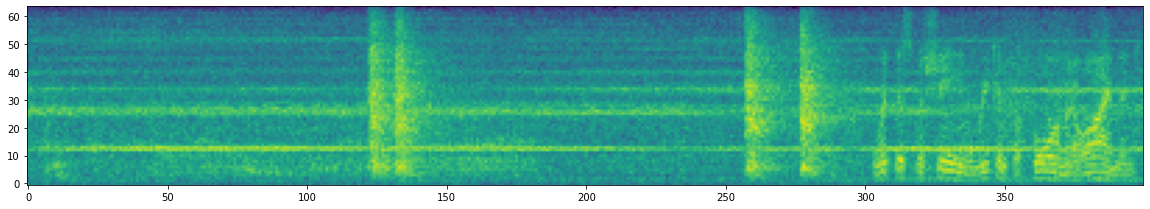

In [120]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [121]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.24451868826290601 0.9397745657275834 2.1961095032687488
 Average | 0.245 | 0.940 | 2.196 
---------+-------+-------+-------
       0 | 0.720 | 0.907 | 1.871 
       1 | 0.031 | 0.776 | 1.075 
       2 | 0.101 | 0.920 | 1.985 
       3 | 0.228 | 0.944 | 2.251 
       4 | 0.253 | 0.963 | 2.531 
       5 | 0.054 | 0.934 | 2.128 
       6 | 0.294 | 0.988 | 3.185 
       7 | 0.431 | 0.985 | 3.061 
       8 | 0.029 | 0.912 | 1.911 
       9 | 0.037 | 0.889 | 1.725 
      10 | 0.135 | 0.927 | 2.056 
      11 | 0.120 | 0.932 | 2.106 
      12 | 0.709 | 0.998 | 4.017 
      13 | 0.452 | 0.993 | 3.462 
      14 | 0.232 | 0.979 | 2.878 
      15 | 0.658 | 0.988 | 3.184 
      16 | 0.366 | 0.969 | 2.632 
      17 | 0.518 | 0.989 | 3.219 
      18 | 0.153 | 0.973 | 2.734 
      19 | 0.150 | 0.969 | 2.647 
      20 | 0.264 | 0.988 | 3.211 
 

# Adversarial Perturbation

In [25]:
from torch.cuda.amp import autocast,GradScaler

In [26]:
import numpy as np
np.unique(gas_eval_y.astype('float16'))
print(np.min(gas_eval_x1), np.max(gas_eval_x1))

-2.2922494 1.4197426


In [27]:
pgd_dataset = torch.utils.data.TensorDataset(torch.from_numpy(gas_eval_x1[:]), torch.from_numpy(gas_eval_y[:].astype('float32')))
pgd_dataloader = torch.utils.data.DataLoader(pgd_dataset, batch_size=25, shuffle=True)

In [28]:
def pgd(model, dataloader, delta_global, num_steps, step_size, step_norm, eps, eps_norm, x_min, x_max, delta_min, delta_max, y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    model.cuda().eval()
    targeted = y_target is not None
    criterion = nn.BCEWithLogitsLoss().cuda()
    loss_global = 0
    for epoch in range(num_steps):
        torch.cuda.empty_cache()
        loss_global = 0
        dataiter = iter(dataloader)
        for step, (feat_a, y) in enumerate(dataiter):
            feat_a = feat_a.cuda()
            
            x_adv_1 = feat_a + delta_global #.to(x.device)
            x_adv_1 = x_adv_1.clamp(x_min, x_max)
            # only video
           
            N_1, T_1, V_1 = x_adv_1.shape
#             print(N_1,T_1,V_1)

            #######   data loaded ###################
            _x_adv_1 = x_adv_1.clone().detach().requires_grad_(True).cuda()

            #######   get gradient #################
#             with torch.no_grad():
#             model.train()# double check
            with autocast():
                out = model(_x_adv_1)
#                 print(out)
#                 out = torch.sigmoid(out)
#                 epsilon = 1e-7
#                 out = torch.clamp(out, epsilon, 1. - epsilon)
#                 temp_out = out.clamp(0,1).cuda()
#                 print(temp_out.shape, y.shape, temp_out.max(), temp_out.min())
#                 print(temp_out.shape, y.shape)

                loss = criterion(out, y.to('cuda', non_blocking=True))
                loss_global += loss.item()
#                 print(loss.item(), loss_global)
                loss.backward()
            ########   updated _x_adv ###############
            with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
                if step_norm == 'inf':
                    gradients = _x_adv_1.grad.sign() * step_size
                else:
                    # The grad is normalized here.
                    # gradients = _x_adv.grad 
                    # Only normalize w.r.t. to feats at a timestep
                    gradients = _x_adv_1.grad/_x_adv_1.grad.norm(step_norm, dim=-1).view(-1, T_1, 1)
                    gradients *= step_size
                if targeted:
                    # Targeted: Gradient descent with on the loss of the (incorrect) target label
                    # w.r.t. the image data
                    x_adv_1 -= gradients
                else:
                    # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                    # the model parameters
                    x_adv_1 += gradients
            # Project back into l_norm ball and correct range
            if eps_norm == 'inf':
                # Workaround as PyTorch doesn't have elementwise clip
                x_adv_1 = torch.max(torch.min(x_adv_1, feat_a + eps), feat_a - eps)
                delta = x_adv_1 - feat_a
            else:
                delta = x_adv_1 - feat_a
#                 delta = delta.renorm(p=eps_norm, dim=0, maxnorm=eps)
            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            # 100 10 2048
#             print(delta)
#             print(delta)
            mask = delta.view(delta.shape[0], -1).norm(float(eps_norm), dim=1) <= eps #100*(20480) => 100
#             print(mask)
            scaling_factor = delta.view(delta.shape[0], T_1, -1).norm(float(eps_norm), dim=-1) #100 10 2048 => 100 40
            scaling_factor[mask] = eps
#             print(scaling_factor)
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / (scaling_factor+1e-7).view(-1, T_1, 1)
#             print(delta)
#             return delta
            delta = delta.float()
            delta = torch.mean(delta,0)
#             print(delta)
            delta_global += delta * N_1 / 20123
            delta_global = delta_global.clamp(delta_min, delta_max)
#             print(delta_global)
            for name, param in model.named_parameters():
                if param.requires_grad:
                    try:
                        param.grad.zero_()
                    except:
                        pass
        print(f'global loss:{loss_global}')
    return delta_global

In [29]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, torch.zeros((400,64)).cuda(), num_steps=20, step_size=0.01, step_norm='inf', eps= 0.1, eps_norm='inf', x_min=np.min(gas_eval_x1), x_max=np.max(gas_eval_x1), delta_min = torch.tensor(np.min(gas_eval_x1) - np.min(gas_eval_x1,axis=0)).cuda(), delta_max = torch.tensor(np.max(gas_eval_x1) - np.max(gas_eval_x1,axis=0)).cuda(), y_target=None )

global loss:10.57658816780895
global loss:10.576867293566465
global loss:10.578444085083902
global loss:10.582849495112896
global loss:10.594685047864914
global loss:10.641768789850175
global loss:11.119314232841134
global loss:12.727481873705983
global loss:13.999449634924531
global loss:14.398344160057604
global loss:14.514746315777302
global loss:14.618591591715813
global loss:14.69363244343549
global loss:14.694797576405108
global loss:14.672871916554868
global loss:14.665239403024316
global loss:14.663431903347373
global loss:14.66147806495428
global loss:14.6567690577358
global loss:14.643164143897593


In [30]:
new_gas_eval = perturb.cpu().numpy() + gas_eval_x1

In [45]:
perturb_noise = perturb.cpu().numpy()*255

In [47]:
print(np.max(perturb_noise),np.min(perturb_noise), np.mean(perturb_noise))

232.69513 0.0 65.66507


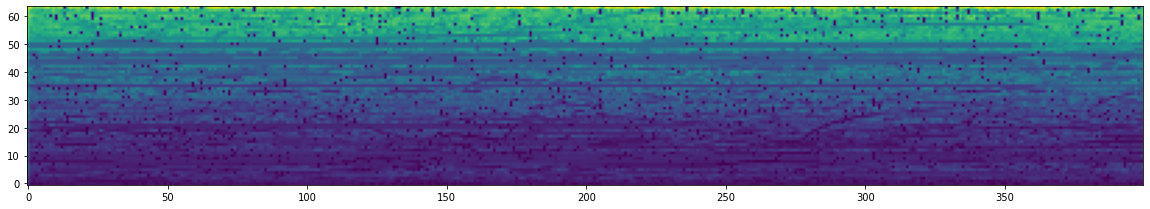

In [48]:

plt.figure(figsize = (20,10))
plt.imshow(perturb_noise.T , origin='lower')
# plt.savefig('imgs/adv_noise_inf_e0.1_step20.png')
with open("imgs/adv_niose_inf.pkl", "wb") as f:
    pickle.dump(perturb_noise, f)

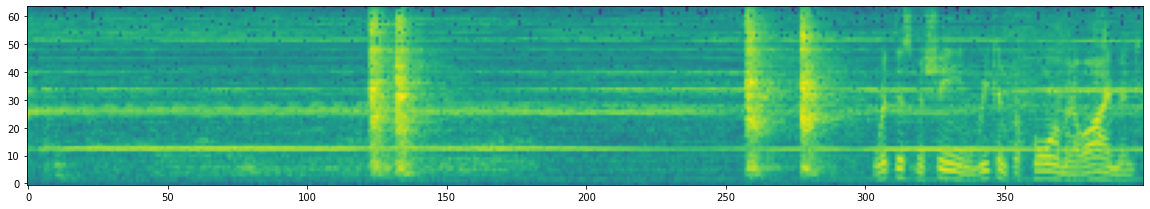

In [31]:

plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')
# plt.imshow(gas_eval_x1[1].T, origin='lower')
# plt.savefig('imgs/hammer_adv_inf_e0.1_step20.png')

In [49]:
print(np.min(new_gas_eval), np.max(new_gas_eval))

-2.2922494 1.4197426


In [50]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.2612427711347847 0.7002749063466139 0.7427327100672536
 Average | 0.261 | 0.700 | 0.743 
---------+-------+-------+-------
       0 | 0.782 | 0.836 | 1.382 
       1 | 0.032 | 0.277 |-0.837 
       2 | 0.052 | 0.490 |-0.036 
       3 | 0.264 | 0.692 | 0.708 
       4 | 0.090 | 0.639 | 0.503 
       5 | 0.073 | 0.622 | 0.438 
       6 | 0.250 | 0.867 | 1.576 
       7 | 0.365 | 0.839 | 1.399 
       8 | 0.077 | 0.602 | 0.367 
       9 | 0.081 | 0.622 | 0.438 
      10 | 0.088 | 0.642 | 0.515 
      11 | 0.179 | 0.668 | 0.616 
      12 | 0.733 | 0.977 | 2.820 
      13 | 0.350 | 0.928 | 2.068 
      14 | 0.269 | 0.822 | 1.305 
      15 | 0.696 | 0.896 | 1.778 
      16 | 0.381 | 0.756 | 0.982 
      17 | 0.569 | 0.899 | 1.801 
      18 | 0.142 | 0.810 | 1.240 
      19 | 0.180 | 0.817 | 1.280 
      20 | 0.295 | 0.889 | 1.729 
      21 | 0.118 | 0

### l2 attack

In [51]:
from torch.cuda.amp import autocast,GradScaler
pgd_dataset = torch.utils.data.TensorDataset(torch.from_numpy(gas_eval_x1[:]), torch.from_numpy(gas_eval_y[:].astype('float32')))
pgd_dataloader = torch.utils.data.DataLoader(pgd_dataset, batch_size=30, shuffle=True)

In [52]:
np.unique(gas_eval_y.astype('float16'))
print(np.min(gas_eval_x1), np.max(gas_eval_x1))

-2.2922494 1.4197426


In [53]:
torch.cuda.empty_cache()

In [54]:
def pgd(model, dataloader, delta_global, num_steps, step_size, step_norm, eps, eps_norm, x_min, x_max, delta_min, delta_max, y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    model.cuda().eval()
    targeted = y_target is not None
    criterion = nn.BCEWithLogitsLoss().cuda()
    loss_global = 0
    for epoch in range(num_steps):
        torch.cuda.empty_cache()
        loss_global = 0
        dataiter = iter(dataloader)
        for step, (feat_a, y) in enumerate(dataiter):
            feat_a = feat_a.cuda()
            
            x_adv_1 = feat_a + delta_global #.to(x.device)
            x_adv_1 = x_adv_1.clamp(x_min, x_max)
            # only video
           
            N_1, T_1, V_1 = x_adv_1.shape
#             print(N_1,T_1,V_1)

            #######   data loaded ###################
            _x_adv_1 = x_adv_1.clone().detach().requires_grad_(True).cuda()

            #######   get gradient #################
#             with torch.no_grad():
#             model.train()# double check
            with autocast():
                out = model(_x_adv_1)
#                 print(out)
#                 out = torch.sigmoid(out)
#                 epsilon = 1e-7
#                 out = torch.clamp(out, epsilon, 1. - epsilon)
#                 temp_out = out.clamp(0,1).cuda()
#                 print(temp_out.shape, y.shape, temp_out.max(), temp_out.min())
#                 print(temp_out.shape, y.shape)

                loss = criterion(out, y.to('cuda', non_blocking=True))
                loss_global += loss.item()
#                 print(loss.item(), loss_global)
                loss.backward()
#             break
            ########   updated _x_adv ###############
            with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
                if step_norm == 'inf':
                    gradients = _x_adv_1.grad.sign() * step_size
                else:
                    # The grad is normalized here.
                    # gradients = _x_adv.grad 
                    # Only normalize w.r.t. to feats at a timestep
                    gradients = _x_adv_1.grad/((1e-10)+_x_adv_1.grad.norm(step_norm, dim=-1).view(-1, T_1, 1))
                    gradients *= step_size
                if targeted:
                    # Targeted: Gradient descent with on the loss of the (incorrect) target label
                    # w.r.t. the image data
                    x_adv_1 -= gradients
                else:
                    # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                    # the model parameters
                    x_adv_1 += gradients
            # Project back into l_norm ball and correct range
            if eps_norm == 'inf':
                # Workaround as PyTorch doesn't have elementwise clip
                x_adv_1 = torch.max(torch.min(x_adv_1, feat_a + eps), feat_a - eps)
                delta = x_adv_1 - feat_a
            else:
                delta = x_adv_1 - feat_a
#                 delta = delta.renorm(p=eps_norm, dim=0, maxnorm=eps).clamp(-1,1)*0.5
            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            # 100 10 2048
#             print(delta)
            mask = delta.view(delta.shape[0], -1).norm(float(eps_norm), dim=1) <= eps #100*(20480) => 100
#             print(mask)
            scaling_factor = delta.view(delta.shape[0], T_1, -1).norm(float(eps_norm), dim=-1) #100 10 2048 => 100 40
#             print(scaling_factor)
            scaling_factor[mask] = eps
#             print(scaling_factor)
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / (scaling_factor+1e-7).view(-1, T_1, 1)
#             print(delta)
#             return delta
            delta = delta.float()
            delta = torch.mean(delta,0)
#             print(delta)
            delta_global += delta * N_1 / 20123
            delta_global = delta_global.clamp(delta_min, delta_max)
#             print(delta_global)
            
            for name, param in model.named_parameters():
                if param.requires_grad:
                    try:
                        param.grad.zero_()
                    except:
                        pass
        print(f'global loss:{loss_global}')
    return delta_global

In [55]:
perturb = pgd(model, pgd_dataloader, torch.zeros((400,64)).cuda(), num_steps=20, step_size=0.01, step_norm=2, eps= 0.1, eps_norm=2, x_min=np.min(gas_eval_x1), x_max=np.max(gas_eval_x1),delta_min = torch.tensor(np.min(gas_eval_x1) - np.min(gas_eval_x1,axis=0)).cuda(), delta_max = torch.tensor(np.max(gas_eval_x1) - np.max(gas_eval_x1,axis=0)).cuda(), y_target=None )

global loss:8.815441593527794
global loss:8.851330389268696
global loss:8.960017655976117
global loss:9.167779535986483
global loss:9.454767460003495
global loss:9.791415185667574
global loss:10.143708334304392
global loss:10.485079535283148
global loss:10.795688109472394
global loss:11.06562019418925
global loss:11.29946199990809
global loss:11.500964814797044
global loss:11.66781542263925
global loss:11.801697380840778
global loss:11.905975666828454
global loss:11.987586982548237
global loss:12.053209339268506
global loss:12.10366839542985
global loss:12.141135837882757
global loss:12.170137144625187


In [59]:
l2_perturb_noise = perturb.cpu().numpy()

In [63]:
print(np.min(l2_perturb_noise), np.max(l2_perturb_noise), np.mean(l2_perturb_noise))

0.0 0.67119807 0.1437689


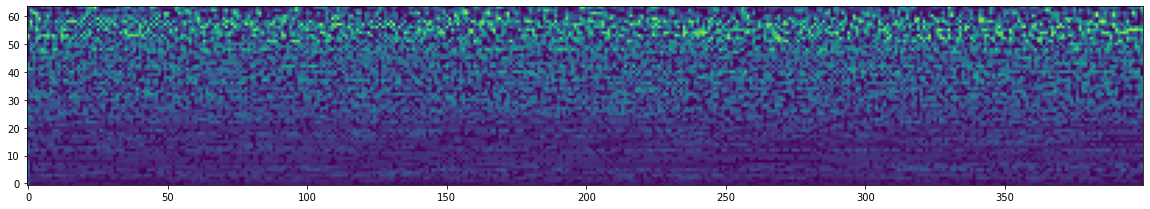

In [67]:

plt.figure(figsize = (20,10))
plt.imshow(l2_perturb_noise.T , origin='lower')
plt.savefig('imgs/adv_noise_l2_e0.1_step20.png')
with open("imgs/l2_adv_niose_inf.pkl", "wb") as f:
    pickle.dump(l2_perturb_noise, f)

In [61]:
new_gas_eval = perturb.cpu().numpy() + gas_eval_x1

In [64]:
print(np.min(new_gas_eval), np.max(new_gas_eval))

-2.2922494 1.4197426


In [65]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.2605827380609454 0.7035352229214247 0.7560322920716659
 Average | 0.261 | 0.704 | 0.756 
---------+-------+-------+-------
       0 | 0.780 | 0.842 | 1.416 
       1 | 0.049 | 0.326 |-0.638 
       2 | 0.078 | 0.553 | 0.189 
       3 | 0.250 | 0.674 | 0.636 
       4 | 0.131 | 0.753 | 0.966 
       5 | 0.056 | 0.602 | 0.367 
       6 | 0.200 | 0.843 | 1.423 
       7 | 0.376 | 0.844 | 1.430 
       8 | 0.058 | 0.592 | 0.328 
       9 | 0.066 | 0.588 | 0.313 
      10 | 0.108 | 0.635 | 0.486 
      11 | 0.164 | 0.647 | 0.533 
      12 | 0.794 | 0.988 | 3.189 
      13 | 0.424 | 0.917 | 1.956 
      14 | 0.222 | 0.785 | 1.118 
      15 | 0.621 | 0.878 | 1.647 
      16 | 0.352 | 0.786 | 1.120 
      17 | 0.449 | 0.866 | 1.570 
      18 | 0.128 | 0.786 | 1.120 
      19 | 0.160 | 0.791 | 1.147 
      20 | 0.286 | 0.878 | 1.649 
      21 | 0.124 | 0

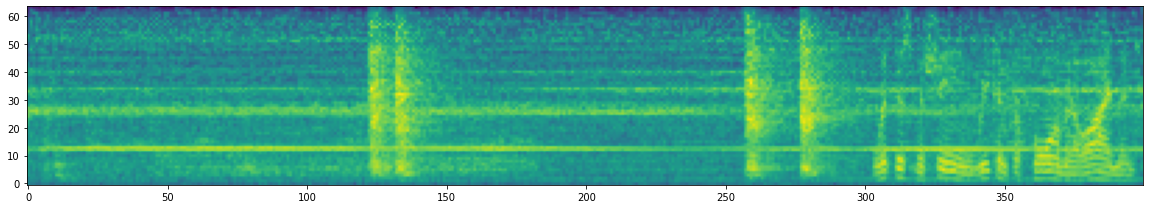

In [66]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [44]:
print(np.min(new_gas_eval), np.max(new_gas_eval))

-2.2922494 1.4197426


## Strong label Masking

In [122]:
hf_val_eval_path = os.path.join(local, 'data_64_400_strong_corrected.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

gas_eval_x1, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

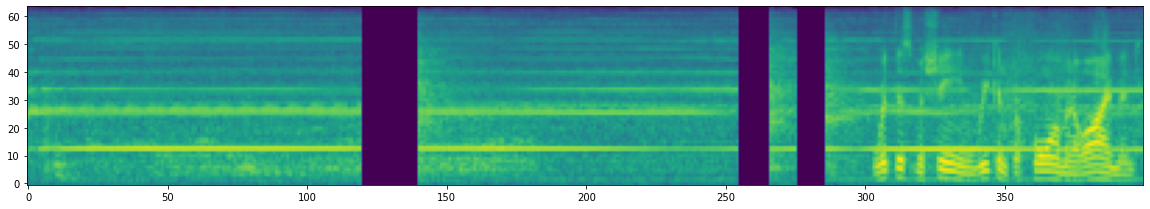

In [123]:
plt.figure(figsize = (20,10))
plt.imshow(gas_eval_x1[1].T, origin='lower')

In [124]:
result = []
batch_size =100
x = gas_eval_x1 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]

total num of batches during testing 202


In [125]:
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.19517087032410663 0.8346825236448412 1.375797480113923
 Average | 0.195 | 0.835 | 1.376 
---------+-------+-------+-------
       0 | 0.603 | 0.790 | 1.140 
       1 | 0.009 | 0.583 | 0.297 
       2 | 0.012 | 0.741 | 0.915 
       3 | 0.184 | 0.814 | 1.260 
       4 | 0.065 | 0.774 | 1.062 
       5 | 0.048 | 0.770 | 1.047 
       6 | 0.256 | 0.905 | 1.857 
       7 | 0.135 | 0.897 | 1.787 
       8 | 0.047 | 0.798 | 1.178 
       9 | 0.036 | 0.766 | 1.026 
      10 | 0.069 | 0.858 | 1.515 
      11 | 0.046 | 0.850 | 1.466 
      12 | 0.273 | 0.840 | 1.406 
      13 | 0.067 | 0.851 | 1.474 
      14 | 0.167 | 0.921 | 1.995 
      15 | 0.390 | 0.939 | 2.183 
      16 | 0.213 | 0.916 | 1.952 
      17 | 0.242 | 0.951 | 2.339 
      18 | 0.108 | 0.918 | 1.970 
      19 | 0.165 | 0.948 | 2.302 
      20 | 0.278 | 0.941 | 2.216 
      21 | 0.088 | 0.921 | 1.997 
      22

# Gaussian Noise Correct from WAV

In [126]:
hf_val_eval_path = os.path.join(local, 'data_64_400_noise0.1.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

noisy_gas_eval_x1, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

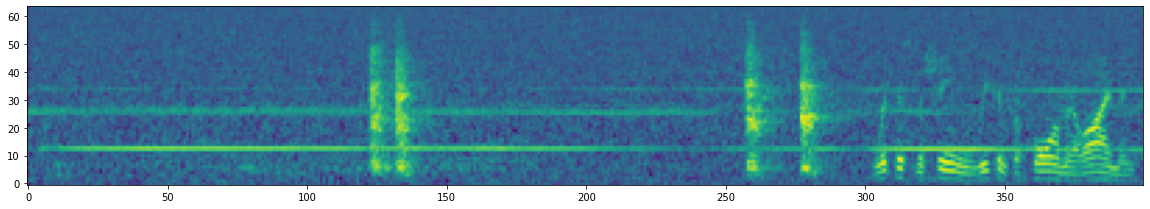

In [127]:
plt.figure(figsize = (20,10))
plt.imshow(noisy_gas_eval_x1[1].T, origin='lower')

In [128]:
result = []
batch_size =100
x = noisy_gas_eval_x1
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]

total num of batches during testing 202


In [129]:
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print("mAP, AUC, dprime:", mAP, mAUC, dprime_val)
print(FORMAT % ('Average', mAP, mAUC, dprime_val))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + (statis[i]['AP'], statis[i]['auc'], d_prime(statis[i]['auc']))))

Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
mAP, AUC, dprime: 0.1852489361102126 0.865120488277584 1.560751074673465
 Average | 0.185 | 0.865 | 1.561 
---------+-------+-------+-------
       0 | 0.655 | 0.867 | 1.574 
       1 | 0.028 | 0.779 | 1.088 
       2 | 0.048 | 0.856 | 1.501 
       3 | 0.231 | 0.936 | 2.150 
       4 | 0.018 | 0.901 | 1.820 
       5 | 0.017 | 0.878 | 1.651 
       6 | 0.083 | 0.923 | 2.014 
       7 | 0.134 | 0.937 | 2.166 
       8 | 0.091 | 0.906 | 1.865 
       9 | 0.085 | 0.888 | 1.721 
      10 | 0.089 | 0.946 | 2.275 
      11 | 0.120 | 0.961 | 2.495 
      12 | 0.765 | 0.999 | 4.290 
      13 | 0.438 | 0.992 | 3.385 
      14 | 0.179 | 0.950 | 2.332 
      15 | 0.002 | 0.235 |-1.023 
      16 | 0.306 | 0.956 | 2.420 
      17 | 0.311 | 0.973 | 2.719 
      18 | 0.070 | 0.951 | 2.347 
      19 | 0.143 | 0.948 | 2.295 
      20 | 0.153 | 0.969 | 2.649 
      21 | 0.050 | 0.920 | 1.986 
      22 |